# Notebook on Diagnosing common LSTM problems and how to tune hyperparameters

## Common mistakes

### Evaluation of model skill
Remember to correctly evaluate your models. If one only trains on training data and evaluate on test data, we take the stochastic nature of deep learning models into consideration, this include random weight initialization, and shuffling after each epoch during SGD.

A recommended way of estimating the skill of a model is shown below. Note that even though this is a recommended way, it might take too  long if you have large amounts of data and have deadlines to meet

In [ ]:
scores = []
for i in some_range:
    train, test = random_split(data)
    model = fit(train.X, train.y)
    predictions = model.predict(test.X)
    skill = compare(test.y, predictions)
    scores.append(skill)
final_skill = mean(scores)

### Unstability of models

When having created a model, it can be a good idea to train the same model on the same dataset, changing only the seed for the random number generator. Afterwards you should review the mean and standard deviation of the scores. If you have a large number as a standard deviation your model might be unstable.

## Diagnosing under- and overfitting 

Start of by looking at the history of the fitted model. Keras tracks various parameters that you specify. Also remember to specify a validation set, if your working on a serious project. The history of parameters from a fitted model in Keras can be retrieved like so

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X, Y, epochs=100, validation_split=0.33)
print(history.history['loss'])
print(history.history['acc'])
print(history.history['val_loss'])
print(history.history['val_acc'])

You can plot these values retrieved from the history method. This gives you a visual perspective on loss and accuracy values. 

In [ ]:
history = model.fit(X, Y, epochs=100, validation_data=(valX, valY))
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

### Underfitting example
An underfit model is one that is demonstrated to perform well on the training dataset and poor
on the test dataset.

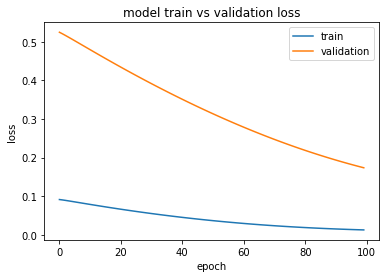

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot
from numpy import array

# return training data
def get_train():
    seq = [[0.0, 0.1], [0.1, 0.2], [0.2, 0.3], [0.3, 0.4], [0.4, 0.5]]
    seq = array(seq)
    X, y = seq[:, 0], seq[:, 1]
    X = X.reshape((len(X), 1, 1))
    return X, y

# return validation data
def get_val():
    seq = [[0.5, 0.6], [0.6, 0.7], [0.7, 0.8], [0.8, 0.9], [0.9, 1.0]]
    seq = array(seq)
    X, y = seq[:, 0], seq[:, 1]
    X = X.reshape((len(X), 1, 1))
    return X, y

# define model
model = Sequential()
model.add(LSTM(10, input_shape=(1,1)))
model.add(Dense(1, activation='linear'))

# compile model
model.compile(loss='mse', optimizer='adam')

# fit model
X,y = get_train()
valX, valY = get_val()
history = model.fit(X, y, epochs=100, 
                    validation_data=(valX, valY),
                    shuffle=False, verbose=0)
# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

Another sign of underperforming models are if performance on training set is a lot better than validation set. Below is an example of a model with too few memory cells, thus underfitting the model. 

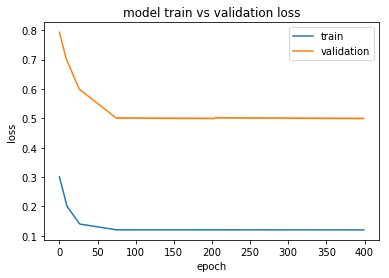

In [3]:
# define model
model = Sequential()
model.add(LSTM(1, input_shape=(1,1)))
model.add(Dense(1, activation='linear'))

# compile model
model.compile(loss='mae', optimizer='sgd')

# fit model
X,y = get_train()
valX, valY = get_val()
history = model.fit(X, y, epochs=400, 
                    validation_data=(valX, valY),
                    shuffle=False, verbose=0)
# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

this example shows the characteristic of an undert model that appears underprovisioned.

### Overfitting example
An overfit model is one where performance on the train set is good and continues to improve, whereas performance on the validation set improves to a point and then begins to degrade.

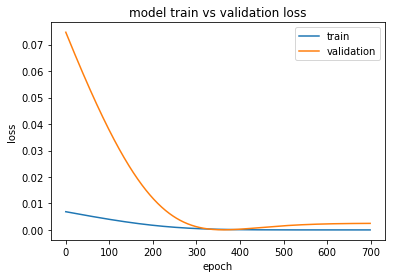

In [9]:
# define model
model = Sequential()
model.add(LSTM(10, input_shape=(1,1)))
model.add(Dense(1, activation='linear'))

# compile model
model.compile(loss='mse', optimizer='adam')

# fit model
X,y = get_train()
valX, valY = get_val()
history = model.fit(X, y, epochs=1200, 
                    validation_data=(valX, valY),
                    shuffle=False, verbose=0)
# plot train and validation loss
pyplot.plot(history.history['loss'][500:])
pyplot.plot(history.history['val_loss'][500:])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

### Plotting multiple model fittings
Multiple fit functions can be a good idea to plot. This way you can see if the over or underfitting is consistent or due to the stochastic nature of NN's

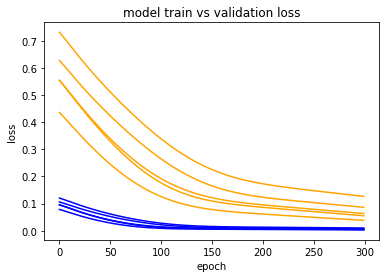

In [12]:
from pandas import DataFrame

train = DataFrame()
val = DataFrame()
for i in range(5):
    # define model
    model = Sequential()
    model.add(LSTM(10, input_shape=(1,1)))
    model.add(Dense(1, activation='linear'))
    # compile model
    model.compile(loss='mse', optimizer='adam')
    X,y = get_train()
    valX, valY = get_val()
    # fit model
    history = model.fit(X, y, epochs=300,
                        validation_data=(valX, valY),
                        shuffle=False, verbose=0)
    # story history
    train[str(i)] = history.history['loss']
    val[str(i)] = history.history['val_loss']
# plot train and validation loss across multiple runs
pyplot.plot(train, color='blue', label='train')
pyplot.plot(val, color='orange', label='validation')
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.show()

## Framing the problem

Outline of biggest things to consider when framing the problem, so that we can create a robust model.

### Scaling values
Try  different ways of scaling you data such as:
  * Normalization 
  * Standardization
  
### Encoding values
Try  different ways of encoding you data such as:
  * Real-value encoding
  * Integer encoding
  * One hot encoding
  * Word2Vec
  * ...
  
### Stationarity
When working with data such as time-series attempt to make the series stationary in order to properly perform statistical analysis. Somem things to do include:
  * Remove trends by you can using differencing.
  * Remove seasonality with seasonal adjustment. 
  * Remove variance by transform values to log.
  
### Sequence Length (n_timesteps)
Remember, the length
of the input sequence also impacts the Backpropagation through time used to estimate the error
gradient when updating the weights. It can have an effect on how quickly the model learns and
what is learned.

### Model type
  * One-to-one.
  * One-to-many.
  * Many-to-one.
  * Many-to-many.
  

## Tune The Model

### Architectures
Choose an appropiate model as those implemente in this repo, or try all of them if in doubt, to see which yields the best result.

### Memory Cells
You can't know the *best* number of cells from the get-go but you have to use either some type of bayesian inference like the sk-opt library. More common ways are things like

  * Grid Search.
  * See quoted papers describing architectures.

### Hidden Layers
  * Try grid searching the number of layers and memory cells together.
  * Try using patterns of stacking LSTM layers quoted in research papers.
  
### Weight Initialization
Some timeseries problems framed in as a regression problem in a specific way, might have to use a linear activation function. If this is the case you have to be careful with weight initialization to avoid vanishing gradients when training the network. here are a couple of mehods to try out. 
  * random uniform
  * random normal
  * glorot uniform
  * glorot normal


### Activation functions

  * Sigmoid
  * ReLu
  * Linear
  * tanh

## Tune Learning Behavior

### Optimization algorithms
A good default implementation of gradient descent is the Adam algorithm. This is because it
automatically uses a custom learning rate for each parameter (weight) in the model, combining
the best properties of the AdaGrad and RMSProp methods.

Other popular optimizers include:
  * RMSprop
  * Adagrad 
  * Nadam
  * SGD
  
### Learning Rate
The learning rate controls how much to update the weights in response to the estimated gradient
at the end of each batch. This can have a large impact on the trade off between how quickly or
how well the model learns the problem. Further more for small LR values a large number of epochs is commonly needed. Consider using same optimzer with different LR values to correctly see the difference.

  * Grid search learning rate values (e.g. 0.1, 0.001, 0.0001).
  * Experiment with a learning rate that decays with the number of epochs (e.g. via callback).
  * Experiment with updating a fit model with training runs with smaller and smaller learning
rates.


### Batch Size
The batch size is the number of samples between updates to the model weights. A good default batch size is 32 samples. Sometimes however it can be reasonable to set the batch size for a larger vvalue in order to fully utilize your GPU at hand for instance. Common values for batch size includes:

* Batch size of 1 for stochastic gradient descent.
* Batch size of n, where n is the number of samples for batch gradient descent.
* Grid search batch sizes in powers of 2 from 2 to 256 and beyond.

### Regularization
To avoid overfitting your model you can use regularitazion to counter it. Dropout randomly skips neurons during training. Dropout values between 0 and 1 are common. In Keras you have 
* dropout: dropout applied on input connections.
* recurrent dropout: dropout applied to recurrent connections.

Experiment with dropout values, and dropout for different layers of your model. 

LSTMs also supports other forms of regularization such as weight regularization that imposes
pressure to decrease the size of network weights. Again, these can be set on the LSTM layer with
the arguments:
* bias regularizer: regularization on the bias weights.
* kernel regularizer: regularization on the input weights.
* recurrent regularizer: regularization on the recurrent weights.

Some have found Dropout on the input connections and regularization on input
weights separately to result in better performing models.